# Interfacing with Stan
This notebook explains how it is possible to interface with [Stan](https://mc-stan.org/) to make use of their awesome library for log-probability calculations, gradient calculation (via autodiff) and their large zoo of probability distributions.

One thing to be mindful of is that the interface below only allows the log probability to be accessed from Stan objects up to an additive constant.

In this notebook, we use the [Eight Schools example](http://pints.readthedocs.io/en/latest/toy/eight_schools.html) and show how the model can be defined in Stan but called from in Pints.

In [1]:
import pints
import pints.toy
import pints.interfaces
import pystan
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.stats

model = pints.toy.EightSchoolsLogPDF()

Define Stan model using their syntax.

In [2]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
"""

## Centered model

Import the Eight Schools ("centered" parameterisation) model from Pints: just to provide the data for fitting the Stan model in Pints.

Use Pints' interface to Stan's models to compile the Stan code and define a Pints model. Also, pickle the model so that it can be reloaded for later use.

In [3]:
# instantiate Pints version of Stan model
stanmodel = pints.interfaces.StanLogPDF(stan_code=code,
                                        stan_data=model.data(),
                                        pickle_filename="test_model.pkl")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6e11919b5314121a277ebece94b64d05 NOW.


Stan model compiled and runs ok...ignore various warnings.


/usr/local/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


Run [HMC](../sampling/hamiltonian-mcmc.ipynb) sampler using this model.

In [4]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = np.random.uniform()
    
mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(1.0)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.25      0.5       0.25      0.5        0:00.0
3     244    0.4       0.4       0.4       0.6        0:00.0
400   32004  0.644     0.719     0.614     0.679      0:05.4
800   64004  0.668     0.721     0.601     0.559      0:10.9
1200  96004  0.65      0.618     0.562     0.567      0:16.4
1600  128004  0.664794  0.562422  0.552     0.589      0:21.8
2000  160004  0.651     0.59      0.486     0.557      0:27.2
2400  192004  0.606     0.601     0.5       0.565      0:32.7
2800  224004  0.61      0.614561  0.522     0.579586   0:38.1
3200  256004  0.583     0.619     0.54      0.602      0:43.6
3600  288004  0.534     0.632     0.559     0.613      0:49.0
4000  319924  0.493     0.638     0.569     0.6198

In [5]:
results = pints.MCMCSummary(chains=full_chains, time=(end-start), parameter_names=stanmodel.names())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mu       3.64    3.56    -3.07   1.24   3.56   6.00   10.77    1.02    124.04  2.28
tau      6.56    4.03    0.98    3.39   5.57   9.27   15.41    1.11    75.65   1.39
theta.1  7.41    6.62    -3.63   2.76   7.00   11.20  22.50    1.03    135.52  2.49
theta.2  4.71    5.70    -6.28   0.88   4.52   8.53   16.13    1.02    175.06  3.22
theta.3  2.50    7.24    -13.72  -1.24  3.03   6.70   15.84    1.07    134.31  2.47
theta.4  4.65    6.26    -6.67   0.89   4.42   8.07   18.68    1.02    141.03  2.59
theta.5  2.49    5.49    -9.68   -0.69  2.78   5.99   12.80    1.03    169.45  3.11
theta.6  2.84    5.85    -9.24   -0.73  2.89   6.44   14.11    1.03    187.07  3.44
theta.7  7.94    6.72    -2.91   3.19   7.05   11.77  23.73    1.04    146.03  2.68
theta.8  3.81    7.45    -9.86   -0.60  3.69   7.82   19.5

The wandering chains here illustrate how difficult inference is for this model.

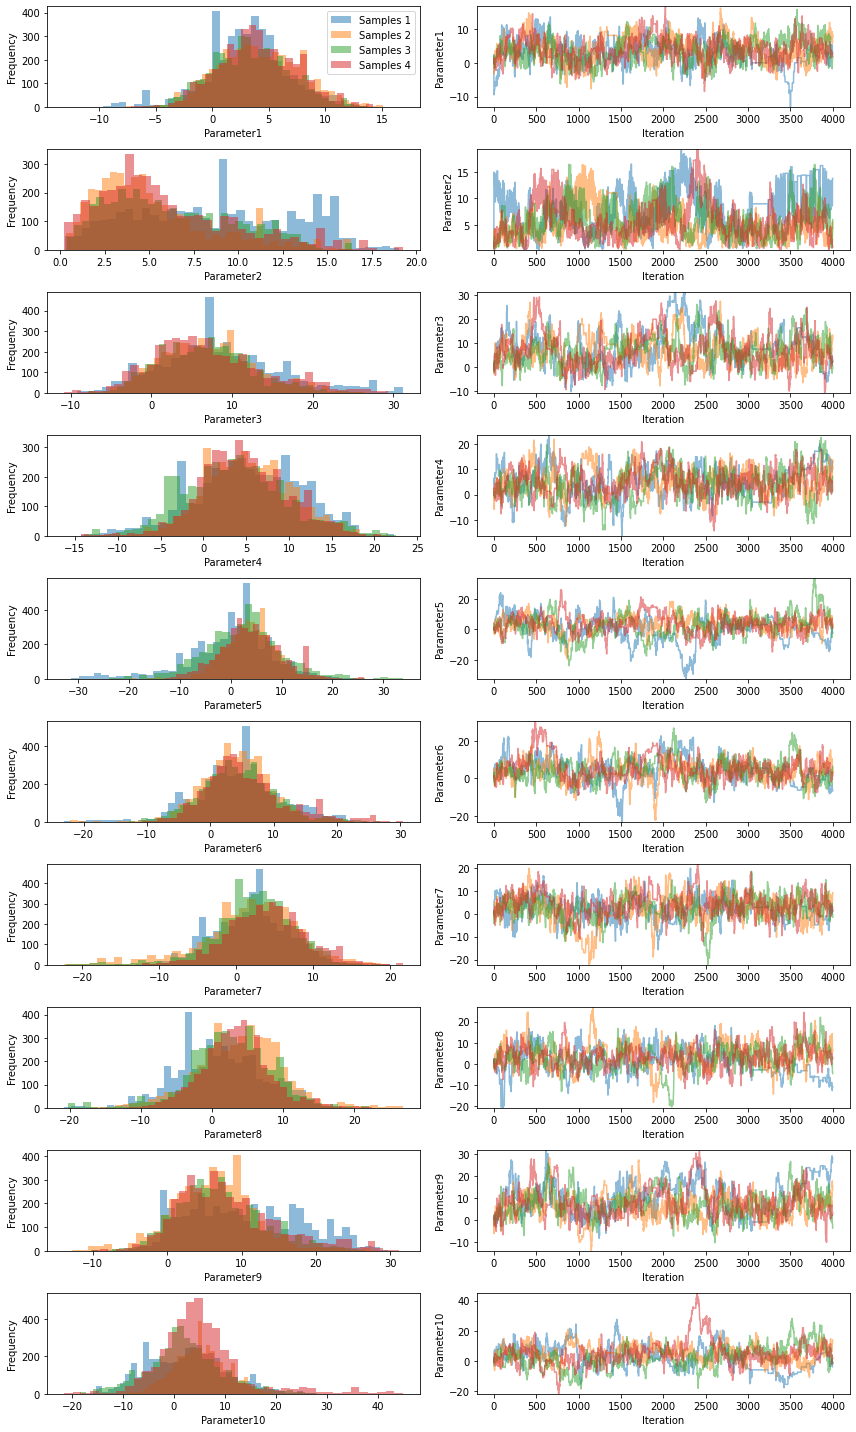

In [6]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()

Just to hammer home the differences between Stan's log probability and Pints': we can compare them for sets of parameter values.

In [7]:
params = np.random.uniform(size=10)

pintsmodel = pints.toy.EightSchoolsLogPDF()

print(str("Stan log prob: " + str(stanmodel(params))))
print(str("Pints log prob: " + str(pintsmodel(params))))

Stan log prob: -0.304408427522449
Pints log prob: -38.45281123158149


But the changes in parameter values should evoke proportional changes in the log-posterior.

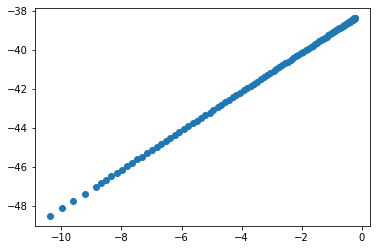

In [8]:
xs = np.linspace(0, 1, 100)
vals_stan = []
vals_pints = []
for x in xs:
    a_params = np.copy(params)
    a_params[0] = x
    vals_stan.append(stanmodel(a_params))
    vals_pints.append(pintsmodel(a_params))
plt.plot(vals_stan, vals_pints, 'o')
plt.show()

Sensitivities however are the same because the constants disappear.

In [9]:
p1, dp1 = stanmodel.evaluateS1(params)
p2, dp2 = pintsmodel.evaluateS1(params)

print(str("Stan d log(prob)/dmu: " + str(dp1[0])))
print(str("Pints d log(prob)/dmu: " + str(dp2[0])))

Stan d log(prob)/dmu: -3.1823910501403923
Pints d log(prob)/dmu: -3.1823910501403936


## Non-centered model

To speed things up, we can move to Stan's non-centered parameterisation. (Pints also has a version of this model: ) This model introduces auxillary variables $\tilde{\theta}_j$ which ensure the joint distribution: $p(\mu,\tau, \boldsymbol{\theta})$ remains the same, but is easier to sample from.

In [10]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
"""

Instantiate Pints version of non-centered Stan model.

In [11]:
stanmodel = pints.interfaces.StanLogPDF(stan_code=code,
                                        stan_data=model.data())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f8f9e8bb354ab461436bb51d935571d NOW.


Stan model compiled and runs ok...ignore various warnings.


/usr/local/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


Retry sampling, this time with the non-centered parameterisation.

In [12]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = np.random.uniform()

mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.25      0.5       0.25       0:00.0
3     244    0.6       0.4       0.6       0.4        0:00.0
400   32004  0.908     0.883     0.945     0.711      0:05.6
800   64004  0.915212  0.884     0.918     0.8        0:11.1
1200  96004  0.918     0.877     0.891015  0.836      0:16.7
1600  128004  0.897628  0.885     0.903     0.843      0:22.4
2000  160004  0.91      0.889     0.891     0.859      0:27.9
2400  192004  0.9       0.895     0.898     0.826811   0:33.5
2800  224004  0.893     0.875     0.867     0.827      0:39.1
3200  256004  0.9       0.841     0.841     0.828      0:44.6
3600  288004  0.904     0.853     0.847     0.822      0:50.1
4000  319924  0.908     0.85      0.854     0.834 

Get back original parameter values: $\theta_j = \mu + \tilde{\theta}_j \tau$.

In [13]:
full_chains_transformed = []
for i in range(len(full_chains)):
    mu = full_chains[i][:, 0]
    tau = full_chains[i][:, 1]
    theta_tilde_j = full_chains[i][:, 2:]
    full_chains_transformed.append(
        np.concatenate((np.transpose(np.vstack((mu, tau))),
                        mu[:, np.newaxis] + (theta_tilde_j * tau[:, np.newaxis])),axis=1).tolist())
full_chains_transformed = np.array(full_chains_transformed)

Aaaaahh, that's better...

In [14]:
results = pints.MCMCSummary(chains=full_chains_transformed,
                            time=(end-start), parameter_names=stanmodel.names())
print(results)

param          mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mu             5.09    3.13    -0.89   2.88   5.07   7.31   11.14    1.03    59.89   1.08
tau            5.10    2.96    0.79    2.85   4.58   6.89   12.33    1.08    57.93   1.04
theta_tilde.1  7.59    6.19    -2.82   3.48   6.89   11.00  22.00    1.02    193.36  3.47
theta_tilde.2  5.89    5.05    -3.61   2.50   5.76   9.05   16.30    1.01    282.57  5.08
theta_tilde.3  4.27    5.93    -7.93   0.90   4.34   7.92   15.41    1.01    203.89  3.66
theta_tilde.4  5.59    5.47    -4.91   2.22   5.30   8.71   17.71    1.02    268.70  4.83
theta_tilde.5  3.47    5.26    -7.82   0.28   3.67   6.88   13.38    1.01    217.26  3.90
theta_tilde.6  4.42    5.47    -7.18   1.10   4.60   8.00   14.49    1.01    202.43  3.64
theta_tilde.7  7.86    5.66    -1.52   3.91   7.28   11.19  20.80    1.01    182.7

...much more efficient sampling!

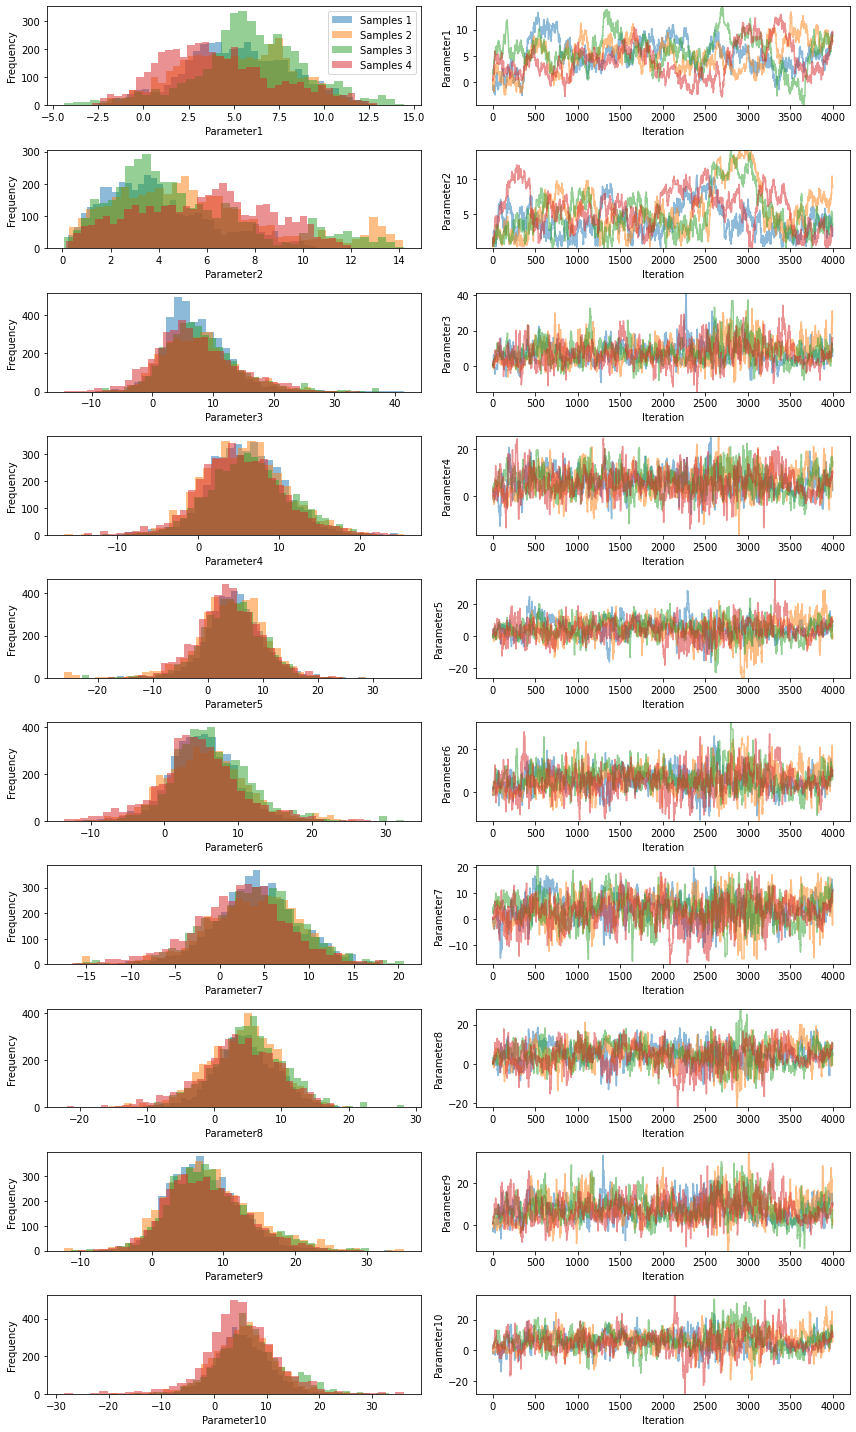

In [15]:
import pints.plot
pints.plot.trace(full_chains_transformed)
plt.show()